# Facebook Advertising KPI Analysis
As one of the largest social media platforms, Facebook enables advertisers to reach diverse audiences and create targeted ads based on a user's age, gender, and other attributes. In this notebook, I explore a real data set from an anonymous organization's Facebook advertising campaign.  I begin the notebook with some exploratory data analysis and then use the data to build some popular advertising key performance indicators.  I then investigate outliers and examine differences in advertising effectiveness among target audiences.  I conclude the analysis by clustering advertisements based on similar key performance indicators.

In [28]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

import statsmodels.api as sm

from scipy.cluster.hierarchy import dendrogram, linkage, ward, fcluster, average, complete
from scipy.stats import ranksums
from scipy.stats import ttest_ind

import warnings

warnings.filterwarnings('ignore')


## Exploratory Data Analysis
The original data set can be found [here](https://www.kaggle.com/loveall/clicks-conversion-tracking/home).

In [2]:
#Read in data
df=pd.read_csv("/Users/mattthometz/Downloads/KAG_conversion_data.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 11 columns):
ad_id                  1143 non-null int64
xyz_campaign_id        1143 non-null int64
fb_campaign_id         1143 non-null int64
age                    1143 non-null object
gender                 1143 non-null object
interest               1143 non-null int64
Impressions            1143 non-null int64
Clicks                 1143 non-null int64
Spent                  1143 non-null float64
Total_Conversion       1143 non-null int64
Approved_Conversion    1143 non-null int64
dtypes: float64(1), int64(8), object(2)
memory usage: 98.3+ KB


,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
0,708746,916,103916,30-34,M,15,7350,1,1.43,2,1
1,708749,916,103917,30-34,M,16,17861,2,1.82,2,0
2,708771,916,103920,30-34,M,20,693,0,0.00,1,0
3,708815,916,103928,30-34,M,28,4259,1,1.25,1,0
4,708818,916,103928,30-34,M,28,4133,1,1.29,1,1


The data set contains 1,143 observations with no missing values.  There are a total of 11 variables, 9 of which are numerical and the other are strings.  Below are the descriptions for each of the variables provided by the documentation for the data set:

1.) ad_id: an unique ID for each ad.

2.) xyz_campaign_id: an ID associated with each ad campaign of XYZ company.

3.) fb_campaign_id: an ID associated with how Facebook tracks each campaign.

4.) age: age of the person to whom the ad is shown.

5.) gender: gender of the person to whim the add is shown

6.) interest: a code specifying the category to which the person’s interest belongs (interests are as mentioned in the person’s Facebook public profile).

7.) Impressions: the number of times the ad was shown.

8.) Clicks: number of clicks on for that ad.

9.) Spent: Amount paid by company xyz to Facebook, to show that ad.

10.) Total conversion: Total number of people who enquired about the product after seeing the ad.

11.) Approved conversion: Total number of people who bought the product after seeing the ad.




In [3]:
print("Unique values for age:", df.age.unique())

Unique values for age: ['30-34' '35-39' '40-44' '45-49']


The unique values for age correspond to the age range of the person to whom the ad is shown.  We might be interested in analyzing trends associated with age, so it makes sense to change these values to the average age of each group.  Since we will need strictly numerical data for examining some correlations later, we can also map the gender category to integers as well.

In [4]:
df=df.replace({'30-34':32, '35-39':37,'40-44': 42,'45-49':47,'F':0,'M':1})

The description of the fb_campaign_id was somewhat unclear in the documentation.  Upon further inspection, it turns out that the fb_campaign_id actually represents the unique target audience determined by the combination of the age, gender, interest, and xyz_campaign_id variables.  

In [5]:
#Check to make sure fb_campaign_id is unique identifier for age, gender, interest, and xyz_campaign_id
for fb_id in df.fb_campaign_id.unique():
    fb_group=df[df.loc[:,'fb_campaign_id']==fb_id]
    if (fb_group.age.nunique()>1) | (fb_group.gender.nunique()>1) | (fb_group.xyz_campaign_id.nunique()>1) | (fb_group.interest.nunique()>1):
        print("Non-Match", fb_id)

In [6]:
#Check unique values in each column
df.nunique()

ad_id                  1143
xyz_campaign_id           3
fb_campaign_id          691
age                       4
gender                    2
interest                 40
Impressions            1130
Clicks                  183
Spent                   869
Total_Conversion         32
Approved_Conversion      16
dtype: int64

As shown above, the data set contains observations for 3 unique ad campaigns for company XYZ.  The documentation for the data set does not specify whether these campaigns are for the same or related products, so we will focus on analyzing the data of a single campaign to ensure the insights we generate are not founded on any erroneous assumptions. Since campaign 1178 has the most observations, we will focus on ads belonging to this campaign for our  analysis.


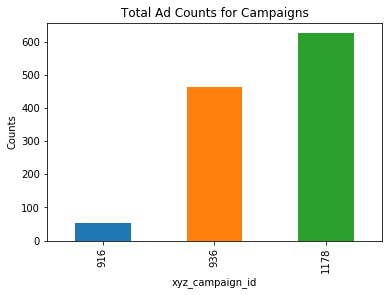

In [7]:
#Create count plots for unique campaigns
df.groupby('xyz_campaign_id').count()['ad_id'].plot(kind='bar')
plt.title('Total Ad Counts for Campaigns')
plt.ylabel('Counts')
plt.show()

In [8]:
#Focus on single ad campaign
campaign = df[df.loc[:,'xyz_campaign_id']==1178]

#Drop uninformative columns
campaign=campaign.drop(columns=['xyz_campaign_id'])
print('\nUnique Entries for each variable\n',campaign.nunique(),'\n')
print('Total number of ads:', len(campaign))
print('Median number of ads per combination of age, gender, interest:',campaign.fb_campaign_id.value_counts().median())



Unique Entries for each variable
 ad_id                  625
fb_campaign_id         277
age                      4
gender                   2
interest                40
Impressions            625
Clicks                 182
Spent                  612
Total_Conversion        32
Approved_Conversion     16
dtype: int64 

Total number of ads: 625
Median number of ads per combination of age, gender, interest: 2.0


Let's take a look at the distributions of the variables and the relationships between them.  The histogram for age shows that the 32-34 age group has more ads than the other groups, and the histogram for gender shows Males has more ads than Females.  While difficult to see in the plot, the histogram for interest is less balanced, with some interest only having 5 ads with others having over 30.  It is evident that the distributions for Impressions, Clicks, Spent, Total_Conversion, and Approved_Conversion have a significant degree of positive skewness.  There also appears to be a very high degree of correlation between several variables.

The correlation matrix confirms that the variables Spent, Clicks, Impressions, Total_Conversion, and Approved_Conversion are all positively correlated with one another.  Spent, Impressions, and Clicks have especially high levels of correlation with one another, with each pair-wise correlation coefficient exceeding .90.  From a business standpoint, these relationships are exactly what we would expect.  Ads with a higher budget can afford more impressions.  With greater exposure, the ad can generate more clicks, which generally lead to more conversions.  In order to generate more useful insight from the data, we need to combine and transform some variables to build key performance indicators (KPI's).


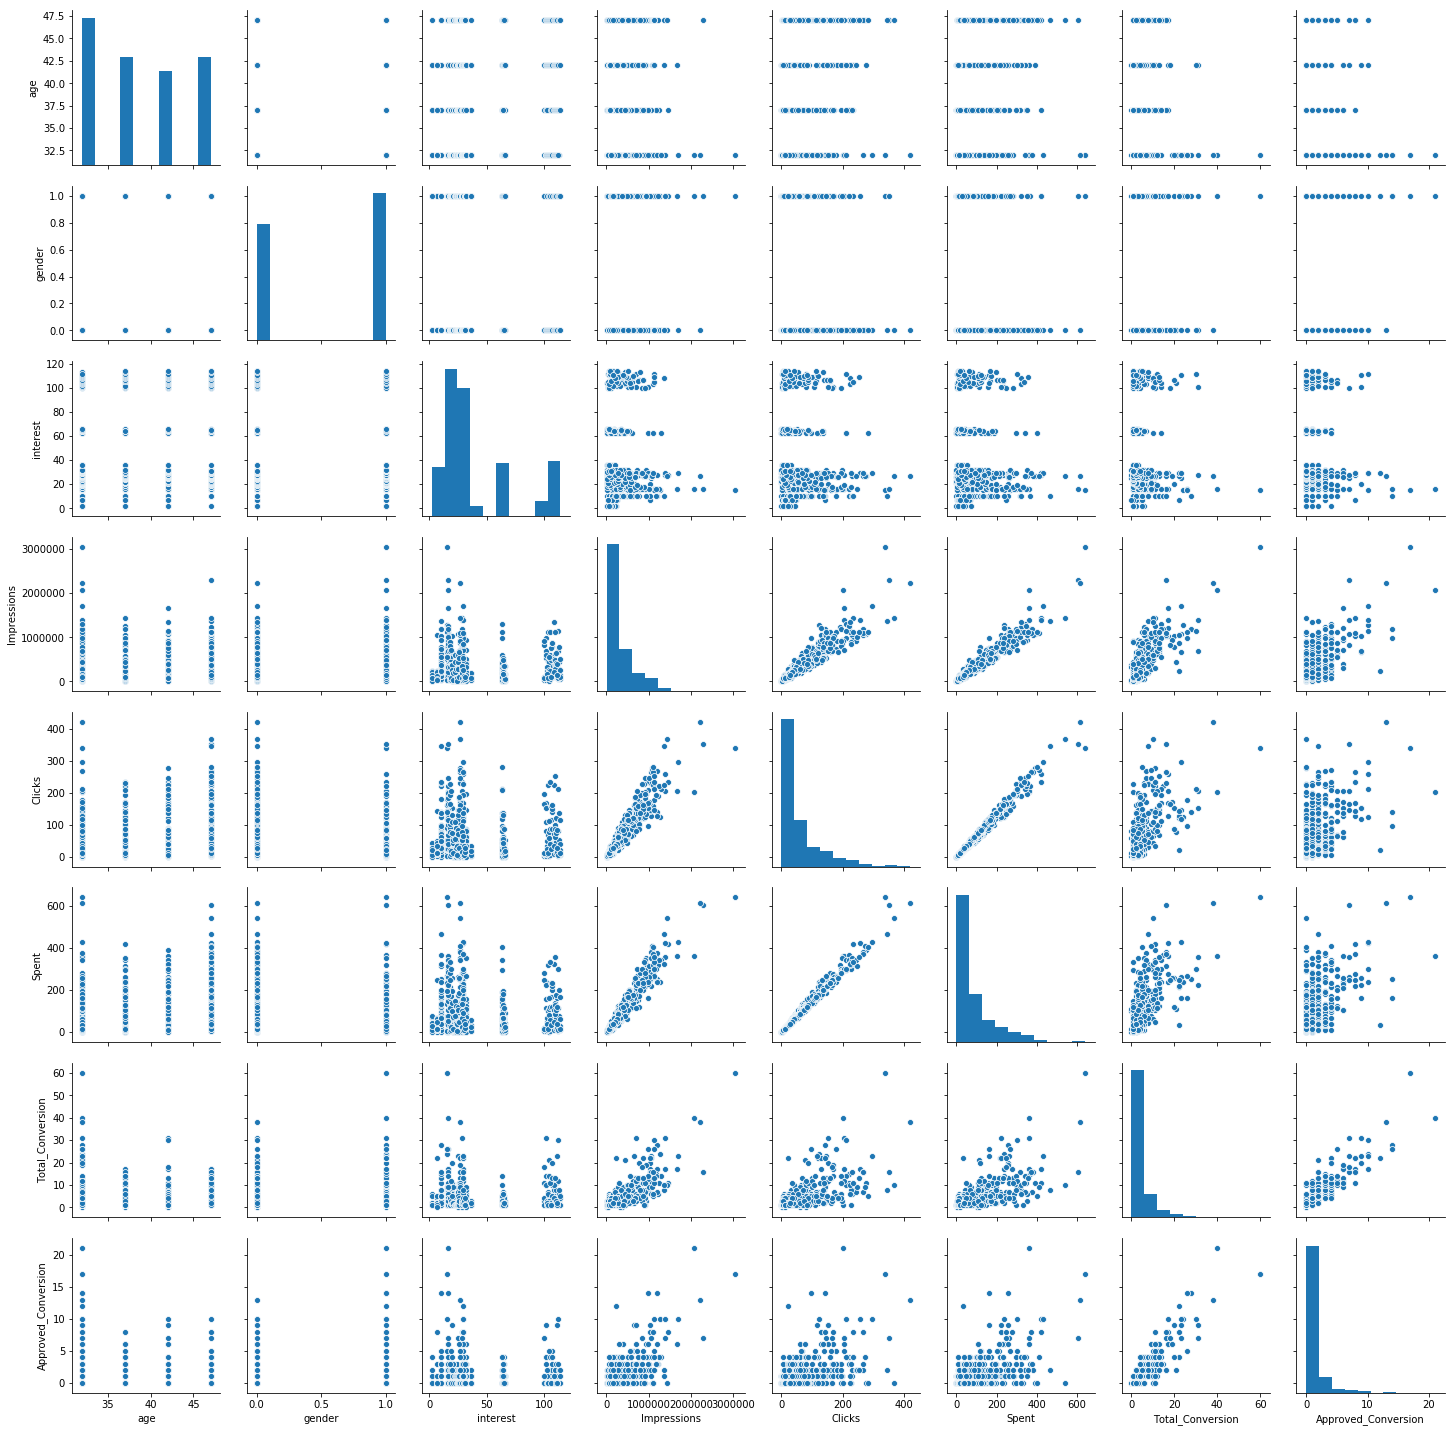

In [9]:
#Create pairplot, exclude uninformative variables
sns.pairplot(campaign.drop(columns=['ad_id','fb_campaign_id']))

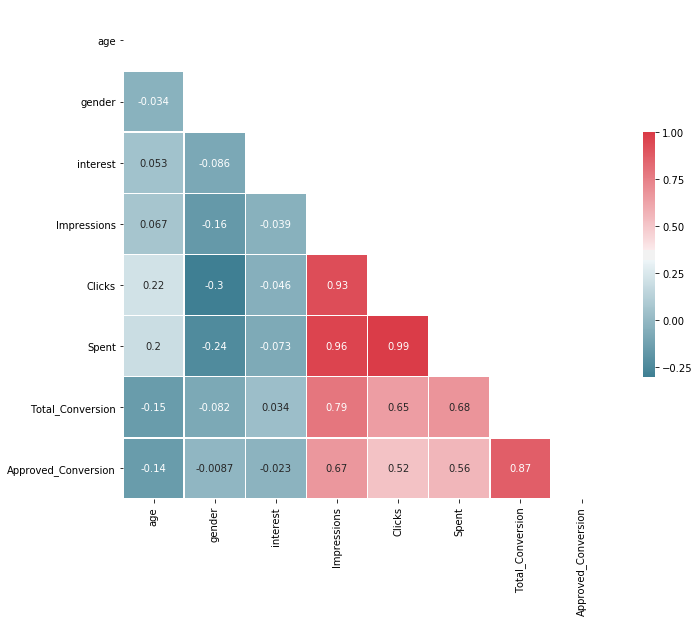

In [10]:
#Create Correlation matrix
corr = campaign.drop(columns=['ad_id','fb_campaign_id']).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

#Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#Plot heat map
sns.heatmap(corr, mask=mask, cmap=cmap, 
            square=True, linewidths=.5,cbar_kws={"shrink": .5},annot=True
           )

## Building KPI's
We can better gauge the effectiveness of an ad by building a few popular KPIs.  KPI's enable companies to tailor their campaign strategies to best meet their business objectives.  With the available data and a few assumptions, we can build the following popular KPI's:

1. Cost Per Mille (CPM): the cost per one thousand impressions

2. Click Through Rate (CTR): the percentage of impressions that become clicks

3. Conversion Rate (CR): the percentage of clicks that become a conversion

4. Cost Per Click (CPC): the average cost associated with each click

5. Return on Advertising Spend (ROAS): ratio between the gross revenue produced by the ad and the cost to run the ad


Depending on the business objectives of a campaign, different KPI's are better suited for assessing its effectiveness.  For example, if a company is mainly focused on improving brand awareness, CPM is an appropriate KPI; whereas, a company looking to maximize the revenue and minimize the cost produced from its ad campaign would likely focus on ROAS.  The documentation for the data set does not provide values for the revenue produced by a Total or Approved conversion, so in order to calculate the ROAS for each ad we need to pick these values.  For this analysis,  I have chosen the conversion values to be `$`10 and `$`90 for Total and Approved conversion, respectively.



In [11]:
#Build KPIs

#Create Cost Per Mille
campaign['CPM']=(campaign.loc[:,'Spent']/campaign.loc[:,'Impressions'])*1000

#Create Click Through Rate
campaign['CTR']=(campaign.loc[:,'Clicks']/campaign.loc[:,'Impressions'])*100

#Create Conversion Rate
campaign['CR_Approved']=(campaign.loc[:,'Approved_Conversion']/campaign.loc[:,'Clicks'])*100
campaign['CR_Total']=(campaign.loc[:,'Total_Conversion']/campaign.loc[:,'Clicks'])*100

#Create Cost Per Click
campaign['CPC']=(campaign.loc[:,'Spent']/campaign.loc[:,'Clicks'])

#Create ROAS
campaign['ROAS']=((campaign.loc[:,'Approved_Conversion']*90)+(campaign.loc[:,'Total_Conversion']*10))/campaign.loc[:,'Spent']

campaign.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 625 entries, 518 to 1142
Data columns (total 16 columns):
ad_id                  625 non-null int64
fb_campaign_id         625 non-null int64
age                    625 non-null int64
gender                 625 non-null int64
interest               625 non-null int64
Impressions            625 non-null int64
Clicks                 625 non-null int64
Spent                  625 non-null float64
Total_Conversion       625 non-null int64
Approved_Conversion    625 non-null int64
CPM                    625 non-null float64
CTR                    625 non-null float64
CR_Approved            616 non-null float64
CR_Total               625 non-null float64
CPC                    613 non-null float64
ROAS                   625 non-null float64
dtypes: float64(7), int64(9)
memory usage: 103.0 KB


Interestingly, there are some null values for the KPI's we created.  Upon further inspection, it is apparent that these null values are coming from observations that have zero clicks but greater than 0 conversions.  Since we do not have any additional information about the campaign or ads to interpret this, it is probably best that we remove these from the data set.

In [12]:
#Inspect rows with null values
campaign[campaign.isnull().any(axis=1)]

,ad_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,CPM,CTR,CR_Approved,CR_Total,CPC,ROAS
520,1121094,144531,32,1,10,24362,0,0.0,1,1,0.0,0.0,inf,inf,NaN,inf
587,1121224,144558,32,1,31,14289,0,0.0,1,0,0.0,0.0,NaN,inf,NaN,inf
599,1121252,144565,32,1,63,11139,0,0.0,1,1,0.0,0.0,inf,inf,NaN,inf
608,1121273,144569,32,1,2,9370,0,0.0,1,1,0.0,0.0,inf,inf,NaN,inf
618,1121286,144571,32,1,66,10991,0,0.0,1,0,0.0,0.0,NaN,inf,NaN,inf
658,1121359,144583,37,1,26,7573,0,0.0,1,0,0.0,0.0,NaN,inf,NaN,inf
669,1121375,144586,37,1,29,9921,0,0.0,1,0,0.0,0.0,NaN,inf,NaN,inf
719,1121477,144603,42,1,21,7073,0,0.0,1,0,0.0,0.0,NaN,inf,NaN,inf
851,1121791,144655,32,0,23,6838,0,0.0,1,0,0.0,0.0,NaN,inf,NaN,inf
880,1121846,144664,32,0,32,8350,0,0.0,1,0,0.0,0.0,NaN,inf,NaN,inf


In [13]:
campaign=campaign.dropna()

## Exploratory Data Analysis Part II
Now that we have created the KPIs, let's take another look at the pair plots and correlation matrix.

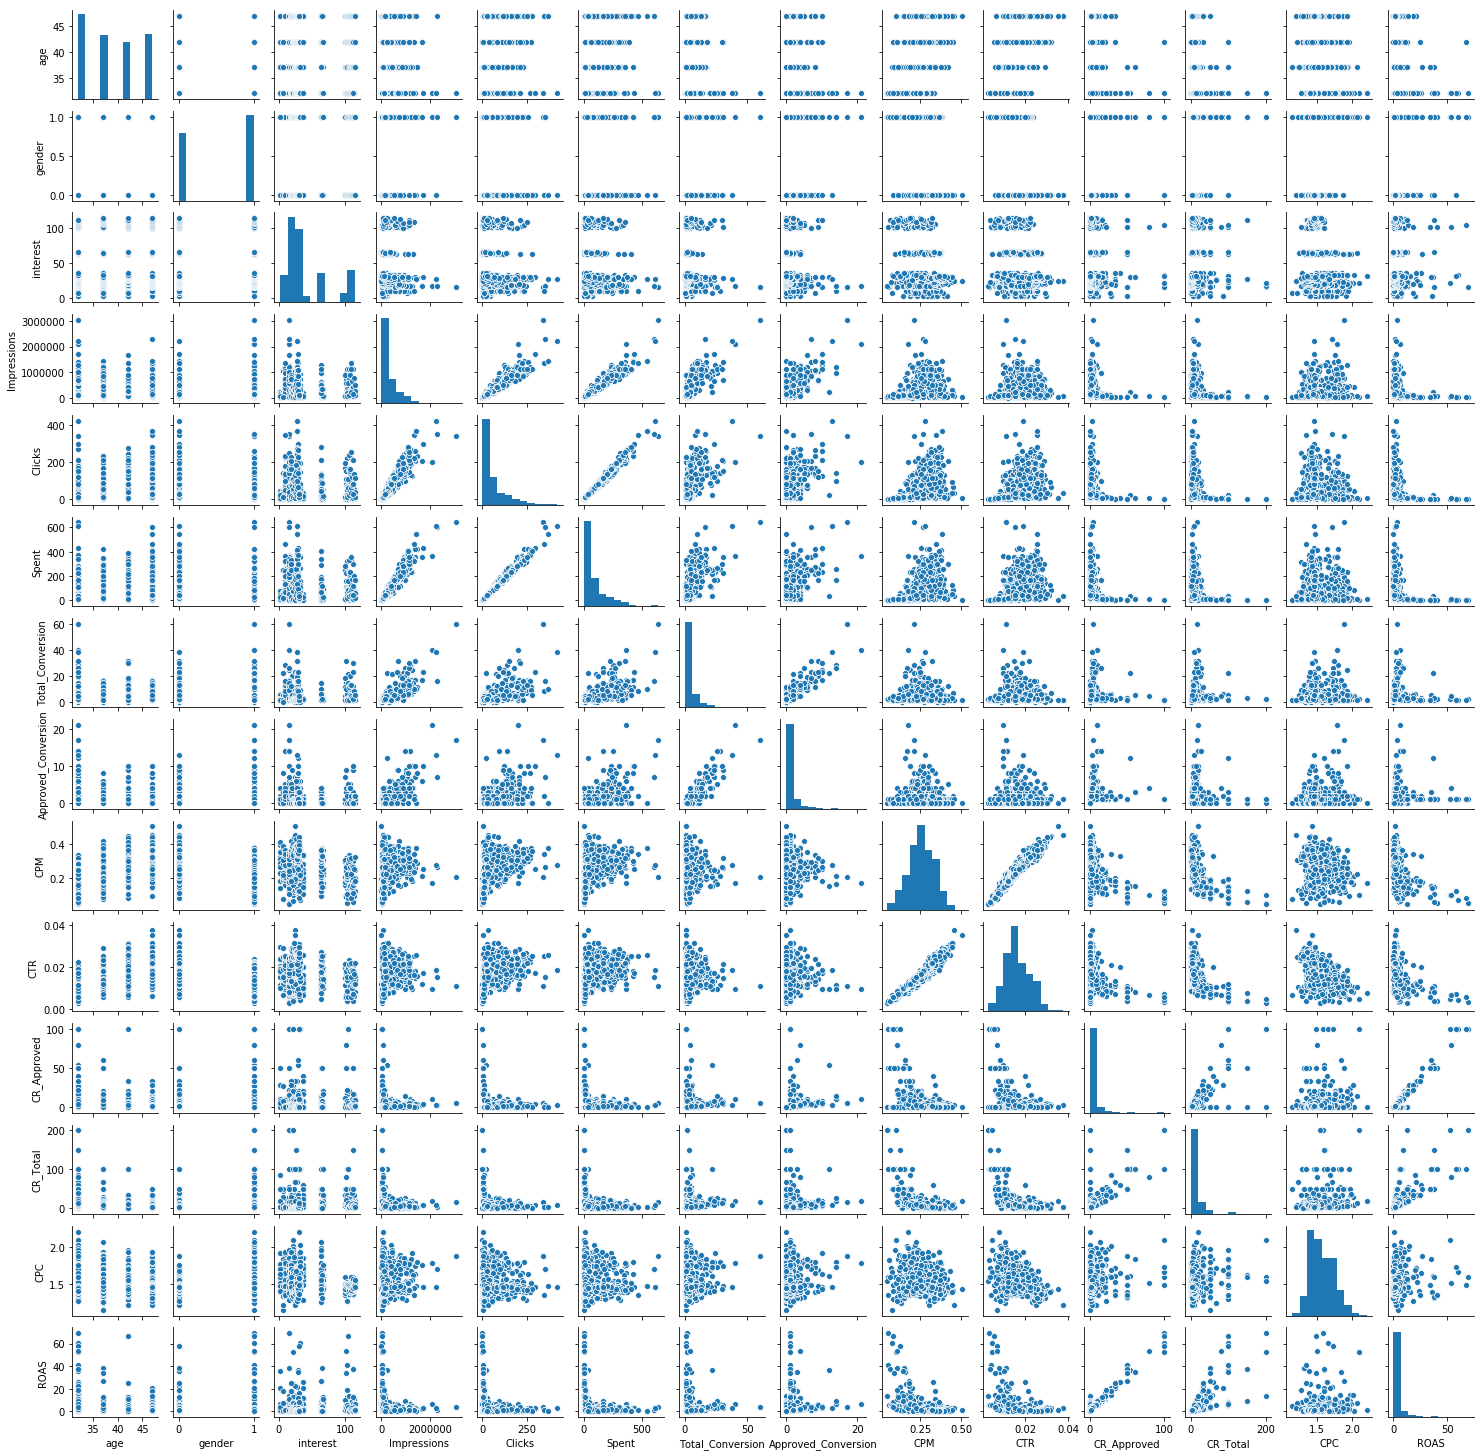

In [14]:
#Create pairplot with KPIs, exclude uninformative variables
f=sns.pairplot(campaign.drop(columns=['ad_id','fb_campaign_id']))
f.fig.set_size_inches(20,20)

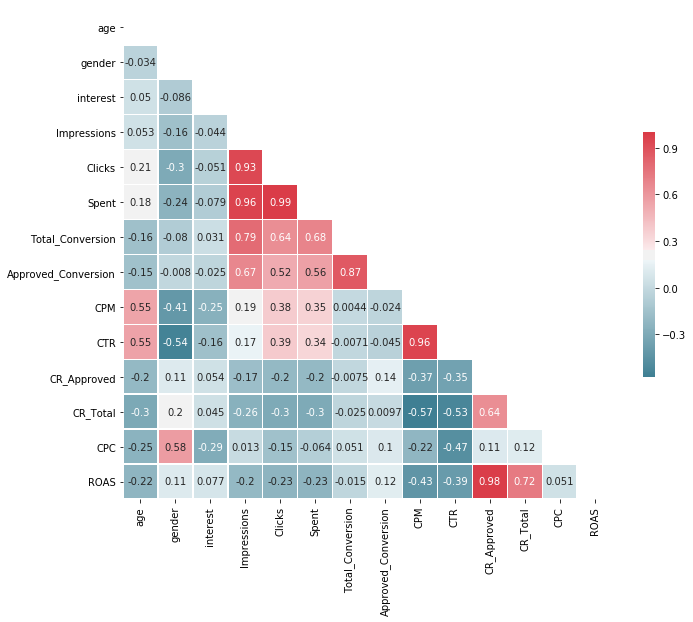

In [15]:
#Create another correlation matrix, with KPI's included
corr = campaign.drop(columns=['ad_id','fb_campaign_id']).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
figure, axes = plt.subplots(figsize=(11, 9))

# Generate a colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, 
            square=True, linewidths=.5,cbar_kws={"shrink": .5},annot=True
           )

The distributions for the CPM, CTR, and CPC look approximately normal.  This is exactly what we expect given the pair-wise linear relationships among Spent, Impressions, and Clicks.  For example, if we regressed Spent onto Clicks and obtained a model with a y-coefficient near zero, the slope of the line should approximate the mean of the distribution of the CPC.  The strong positive correlation between CPM and CTR is also expected because of the linear relationship between Spent and Clicks.

Since most ads have a small number of conversions, the distributions for CR_Total, CR_Approved, and ROAS all display a significant degree of positive skewness and also appear to have some significant outliers.  Interestingly, many of the data points with a very high ROAS, CR_Total, and CR_Approved have a relatively low number of impressions, clicks, and money spent.  These data points definitely warrant further investigation from a statistical and business standpoint.  If the objective of an ad campaign is to maximize ROAS, it could be incredibly useful to identify the specific ads that have a good ROAS since it may make sense to increase the amount of funding allocated to these ads.  On the other hand, the fact that these data points have a low number of impressions, clicks, and money spent suggests that these advertisments were not run at as large of a scale as many other ads, which may make it more difficult to make meaningful comparisons and confidently make business decisions based on the data.  In either case, we should definitely look these data points more closely.  Let's isolate the advertisements that are outliers based on ROAS.

## ROAS Outlier Investigation
The presence of extreme outliers can inflate the standard deviation, and thus effectively mask themselves.  To remedy this masking, we can use a more robust method involving the median and median absolute deviation to identify ROAS outliers.  Once we have identified these outliers, we can look for patterns within other features such as clicks and spent.  We may also be able to gain important insight into what demographics are responding best to the campaign by looking at these features within the outlier data.  

In [16]:
roas_mad=sm.robust.mad(campaign['ROAS'])
roas_std=campaign['ROAS'].std()
roas_mean=campaign['ROAS'].mean()
roas_med=campaign['ROAS'].median()
roas_med_outlier_val=(roas_med+(2*roas_mad)/.6745)
campaign['ROAS_class']=np.where(campaign['ROAS']>roas_med_outlier_val,'Outlier','Non-Outlier')
outliers=campaign[campaign['ROAS_class']=='Outlier']
non_outliers=campaign[campaign['ROAS_class']=='Non-Outlier']
print('ROAS mean:',roas_mean,' ROAS standard deviation:', roas_std)
print('ROAS median:', roas_med,' ROAS median absolute deviation', roas_mad)
print('Outliers detected using median-based method:', len(outliers))

ROAS mean: 3.9110675537337927  ROAS standard deviation: 7.792016531052357
ROAS median: 1.7724782348623773  ROAS median absolute deviation 1.9232213168395442
Outliers detected using median-based method: 63


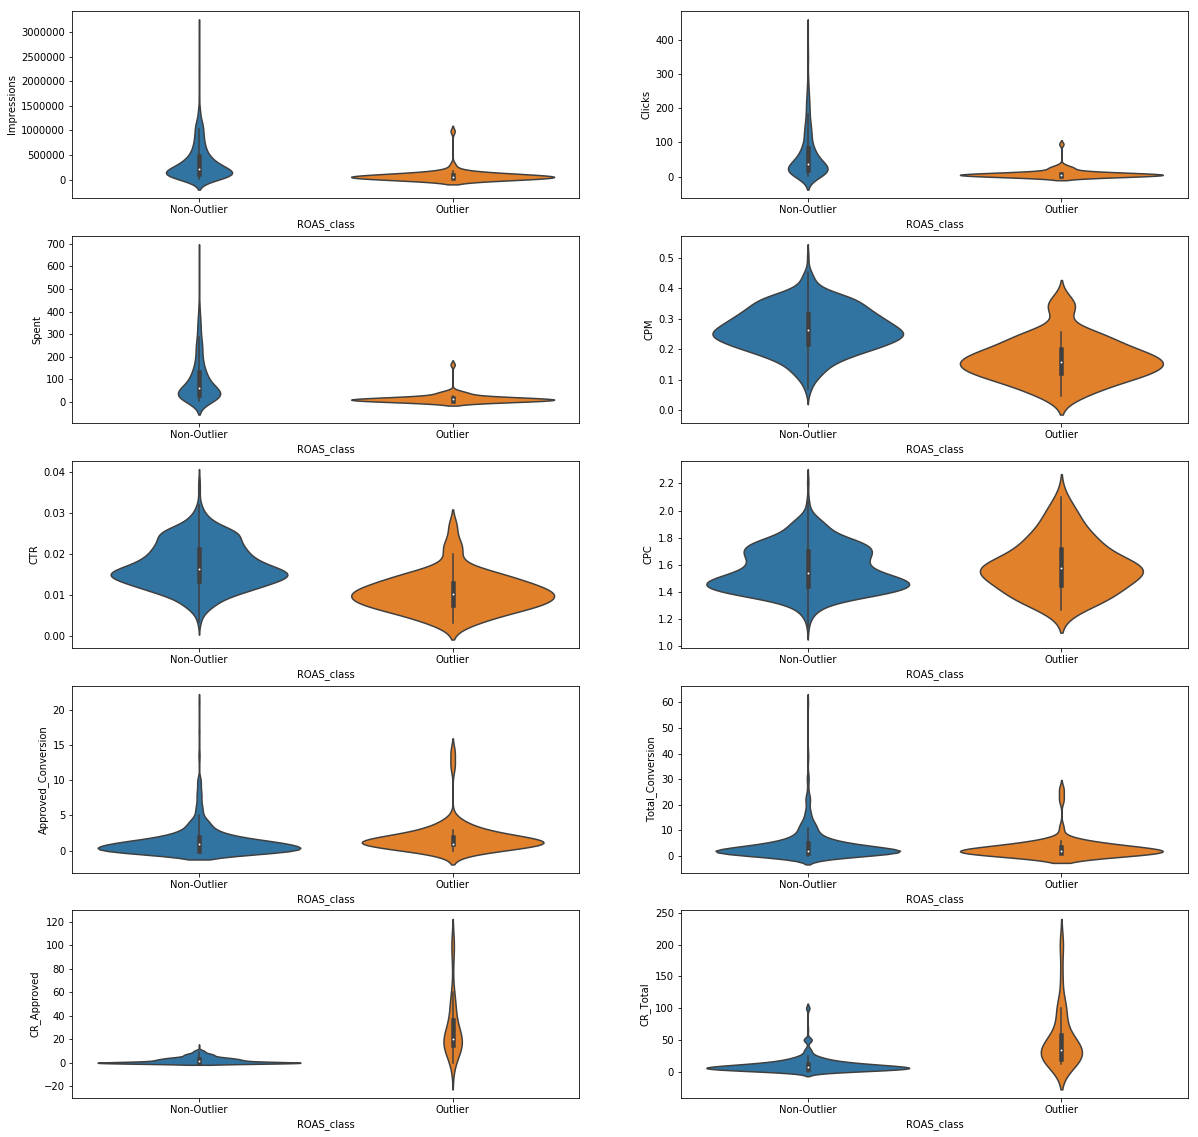

In [17]:
figure,axes = plt.subplots(ncols=2,nrows=5,figsize=(20,20))
sns.violinplot(x='ROAS_class',y='Impressions',data=campaign, inner='box',ax=axes[0,0])
sns.violinplot(x='ROAS_class',y='Clicks',data=campaign, inner='box',ax=axes[0,1])
sns.violinplot(x='ROAS_class',y='Spent',data=campaign, inner='box',ax=axes[1,0])
sns.violinplot(x='ROAS_class',y='CPM',data=campaign, inner='box',ax=axes[1,1])
sns.violinplot(x='ROAS_class',y='CTR',data=campaign, inner='box',ax=axes[2,0])
sns.violinplot(x='ROAS_class',y='CPC',data=campaign, inner='box',ax=axes[2,1])
sns.violinplot(x='ROAS_class',y='Approved_Conversion',data=campaign, inner='box',ax=axes[3,0])
sns.violinplot(x='ROAS_class',y='Total_Conversion',data=campaign, inner='box',ax=axes[3,1])
sns.violinplot(x='ROAS_class',y='CR_Approved',data=campaign, inner='box',ax=axes[4,0])
sns.violinplot(x='ROAS_class',y='CR_Total',data=campaign, inner='box',ax=axes[4,1])

Using the median-based outlier detection method, we have identified 63 points with extreme ROAS values.  If we use the number of impressions as a proxy for the scale of the advertisement, we can test whether the outlier ads were not run at as large of a scale as the other ads.  We can also tests if any of the other variables are significantly different from the non-outliers to gain more insight into the characteristics of these advertisements.  As evidenced by the violin plots for variables split by ROAS_Class (Outlier vs Non-Outlier), the normal distribution may not be the best approximation for the distributions, so a non parametic test such as the Wilcoxon rank sum test can be used to test the null hypothesis that the distributions are equal.  This test is also well suited for this comparison since it is robust to outliers.  

In [18]:
#Create list of variables for hypothesis testing
hyp_var=['Impressions','Clicks','Spent','CPM','CTR','CPC',
         'Approved_Conversion','Total_Conversion','CR_Approved','CR_Total']

#Pick significance level .01
alpha=.01

#Perform hypothesis tests
for var in hyp_var:
    test_stat,p_value=ranksums(x=non_outliers[var],y=outliers[var])
    print('For {0} p-value = {1:.3e}'.format(var,p_value),
          ' Reject the null hypothesis' if p_value<alpha else "Fail to reject the null hypothesis")

For Impressions p-value = 2.982e-20  Reject the null hypothesis
For Clicks p-value = 3.124e-24  Reject the null hypothesis
For Spent p-value = 2.647e-24  Reject the null hypothesis
For CPM p-value = 1.839e-18  Reject the null hypothesis
For CTR p-value = 4.472e-18  Reject the null hypothesis
For CPC p-value = 4.677e-01 Fail to reject the null hypothesis
For Approved_Conversion p-value = 1.012e-04  Reject the null hypothesis
For Total_Conversion p-value = 5.752e-02 Fail to reject the null hypothesis
For CR_Approved p-value = 3.774e-33  Reject the null hypothesis
For CR_Total p-value = 3.450e-30  Reject the null hypothesis


For the hypothesis tests, the p-value was smaller than the significance level of .01 for every tests except CPC and and Total Conversion, so there is a statistically significant difference between the distributions for the other variables.  The number of impressions, clicks, money spent, CPM, and CTR is lower for the ROAS outliers than the ROAS non-outliers, while the number of approved conversions, approved conversion rate and total conversion rate is higher.  While many of these conclusions are not surprising, others provide valuable insight that can help guide decision making.  Notably, the CPM is lower, so this indicates it is cheaper to run these ads.  Interestingly, the CTR is also lower, so less people are engaging with the ads, but the approved conversions and conversion rates are higher, so the individuals that do click are more likely to convert.  Since the CTR is lower, it may be worthwhile to rethink the design, message, or placement of these advertisements to help generate more clicks.  The ads are already cheaper on average, so increasing spending to improve the CTR could have a substantial impact on revenue assuming the conversion rates remain high.

We can also gain important insight into what demographics are responding best to the campaign by taking a closer look at the proportions of certain demographics in the outlier data.

In [19]:
def test_proportions(df1,df2,var,alpha):
    '''Tests whether the population proportions are significantly different for each
        of the unique values in var'''
    unique_vals=set(list(df1[var].unique())+list(df2[var].unique()))
    reject=[]
    for val in unique_vals:
        s1=len(df1[df1[var]==val])
        n1=len(df1)
        s2=len(df2[df2[var]==val])
        n2=len(df2)
        z, p_value = sm.stats.proportions_ztest([s1, s2], [n1, n2])
        if p_value<alpha: 
            reject.append(val)
            print("For",var,val,"p-value",p_value)
            print("Conclusion: Reject the null hypothesis")
    print('\n')
    return reject
#Test proportions for gender,age
alpha=.01
reject_age=test_proportions(outliers,non_outliers,'age',alpha)
reject_gender=test_proportions(outliers,non_outliers,'gender',alpha)
reject_interest=test_proportions(outliers,non_outliers,'interest',alpha)


For age 32 p-value 4.2835041455809786e-05
Conclusion: Reject the null hypothesis
For age 47 p-value 0.0015065941671798292
Conclusion: Reject the null hypothesis


For gender 0 p-value 0.0033606236876531567
Conclusion: Reject the null hypothesis
For gender 1 p-value 0.003360623687653165
Conclusion: Reject the null hypothesis


For interest 31 p-value 0.0015207297910885547
Conclusion: Reject the null hypothesis
For interest 36 p-value 0.0007182263191626454
Conclusion: Reject the null hypothesis




From these tests, we can see the proportions of the following groups in the outliers are significantly different from the rest of the campaign:

Age: 30-34 and 45-49 <br>
Gender: Male and Female <br>
Interest: 31 and 36 <br>

As evidenced in the bar plots below, the 30-34 age group is over-represented in the outliers while 45-49 group is underrepresented.  Males are over-represented while females are underrepresented.  Interest 31 is underrepresented while interest 36 is overrepresented.

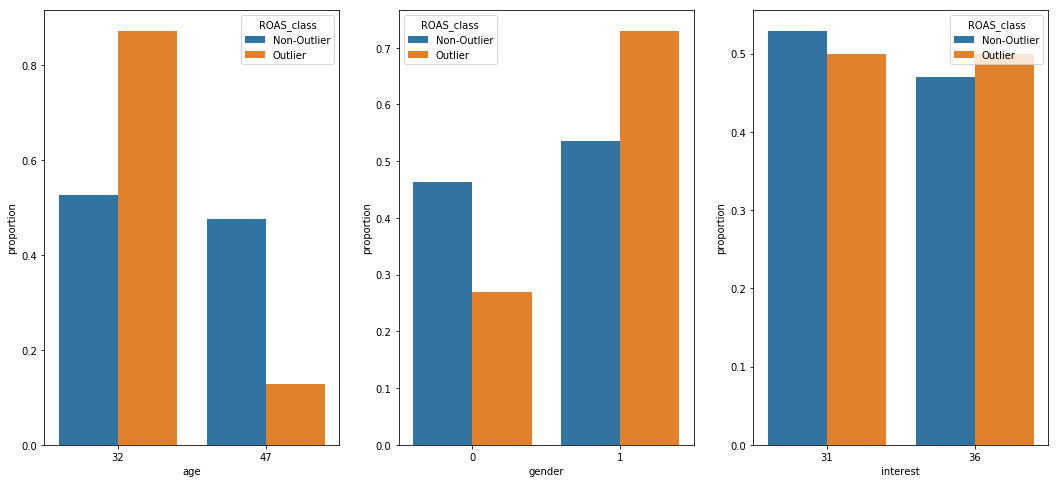

In [20]:
def make_subgroup(df,var,var_subgroup_list):
    '''Creates a dataframe where the value of var is in var_subgroup_list'''
    df_sub=df.ix[[i for i,n in df[var].iteritems() if n in var_subgroup_list]]
    return df_sub

#Create dfs with only statistically significant subgroups for plotting
subgroup_age=make_subgroup(outliers,'age',reject_age).append(make_subgroup(non_outliers,'age',reject_age))
subgroup_gender=make_subgroup(outliers,'gender',reject_gender).append(make_subgroup(non_outliers,'gender',reject_gender))
subgroup_interest=make_subgroup(outliers,'interest',reject_interest).append(make_subgroup(non_outliers,'interest',reject_interest))

def plot_proportions(df,var,hue,ax):
    '''Plots relative proportions of var in df separated by hue'''
    y='proportion'
    proportion=df[var].groupby(df[hue]).value_counts(normalize=True).rename(y).reset_index()
    return sns.barplot(x=var, y=y, hue=hue, data=proportion,ax=ax)

#outliers[age_mask | interest_mask]
figure, axes = plt.subplots(ncols=3,figsize=(18,8))
f1=plot_proportions(subgroup_age,'age','ROAS_class',ax=axes[0])
f2=plot_proportions(subgroup_gender,'gender','ROAS_class',ax=axes[1])
f3=plot_proportions(subgroup_interest,'interest','ROAS_class',ax=axes[2])



We can gain even more insight by determining whether the demographics over-represented in the outliers also have a better ROAS than the other groups with the outliers removed.  For the sake of our analysis, we will focus on the ROAS split by gender.

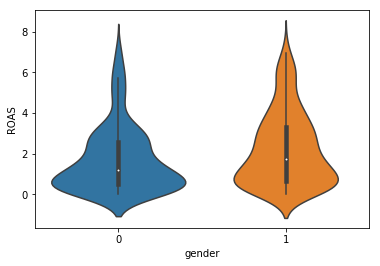

In [21]:
sns.violinplot(x='gender',y='ROAS',data=non_outliers, inner='box')


In [22]:
gender=ranksums(x=non_outliers[non_outliers['gender']==0].loc[:,'ROAS'],y=non_outliers[non_outliers['gender']==1].loc[:,'ROAS'])
print('Gender p-value:',gender[1])


Gender p-value: 0.00019364375656208996


As evidenced by the violin plot for ROAS split by gender (with outliers removed), the normal distribution may not be the best approximation for the distributions, so the Wilcoxon rank sum test can be used to test the null hypothesis that the distributions for the ROAS split by gender are equal.  For the hypothesis test, the p-value was smaller than the significance level of .01, so we can reject the null hypothesis and conclude that there is a statistically significant difference between the ROAS split by gender.  That is, the ROAS is higher for males than it is for females, even after removing the outliers.  From a business perspective, this can help guide important decisions regarding advertising spending.  For the whole campaign (outliers included), the amount spent on ads targeting women is over 35% higher than that spent on men, but the gross revenue produced by ads targeting women is 16% lower than the gross revenue produced by ads targeting men.  More money is being spent on targeting females and producing less revenue than ads targeting males, so it may make sense to allocate more funding towards ads targeting males.

In [23]:
tot_spent_males=campaign[campaign['gender']==1].Spent.sum()
tot_spent_females=campaign[campaign['gender']==0].Spent.sum()
print("Amount spent on ads targeted to Males:", tot_spent_males)
print("Amount spent on ads targeted to Females:", tot_spent_females)
print("Percent greater spent on Female Ads {:.2%}".format((tot_spent_females-tot_spent_males)/tot_spent_males))
gross_rev_males=(campaign[campaign['gender']==1].Total_Conversion.sum()*10)+(campaign[campaign['gender']==1].Approved_Conversion.sum()*90)
gross_rev_females=(campaign[campaign['gender']==0].Total_Conversion.sum()*10)+(campaign[campaign['gender']==0].Approved_Conversion.sum()*90)
print("Gross revenue produced by ads targeted to Males:", gross_rev_males)
print("Gross revenue produced by ads targeted to Females:", gross_rev_females)
print("Percent less gross revenue produced by ads targeted to females {:.2%}".format((gross_rev_females-gross_rev_males)/gross_rev_females))


Amount spent on ads targeted to Males: 23609.739993968
Amount spent on ads targeted to Females: 32052.409964646
Percent greater spent on Female Ads 35.76%
Gross revenue produced by ads targeted to Males: 56410
Gross revenue produced by ads targeted to Females: 48370
Percent less gross revenue produced by ads targeted to females -16.62%


We have been able to gain a fair amount of insight from the data by examining outliers and looking at differences in ROAS stratified by demographics such as gender.  We can dive even deeper into the data by looking at  differences in KPIs on a finer level, for example, by looking at these differences stratified by gender and age.  This type of analysis is useful, but we have to be careful about some of conclusions we draw since there is less data to support our claims at these finer levels of granularity.  

So far, we have mainly focused on ROAS for our analysis, which is an important KPI, but it does not tell the whole story when considered in isolation, as we noticed when examining the KPIs for the ROAS outliers.  It could be incredibly useful expand this analysis and segment advertisements on the basis of similarities among the KPI's and other variables.  To accomplish this, we can employ a clustering technique known as hierarchical clustering.

## Hierarchical Clustering

Hierarchical clustering is a powerful clustering technique that is especially useful when we do not know how many segments there are in the data.  The output of a hierarchical clustering algorithm can be visualized as a dendrogram, a upside-down tree-based representation of the observations which allows us to quickly see clusterings at different granularities. 

There are two main strategies for performing hierarchical clustering:
<br>1) Agglomerative: "The bottom up approach", each observation begins as its own cluster and observations are merged with each other as one moves up the hierarchy<br>
2) Divisive : "The top down approach", all observations begin in one cluster and recursively split as one moves down the hierarchy

For our analysis, we will use agglomerative clustering, since it is generally more efficient than divisive clustering and Python has several packages that support agglomerative hierarchical clustering techniques.  In agglomerative clustering, the lowest level or leaves of the dendrogram represent a single observation.  As we traverse up the tree, the leaves fuse together into clusters.  The lower in the tree that this fusion occurs, the greater the similarity  between the observations or clusters.  In other words, the height of the fusion indicates the level of dissimilarity between the obervations or clusters that are being merged together.

In order to determine how clusters should be merged, we need to pick a metric to define the distance between pairs of observations and a linkage criterion which specifies the dissimilarity of sets as a function of the pairwise distances of observations in the sets.  We will use the Euclidean distance between observations for our metric and Ward's method for our linkage criterion.  In Ward's method, the criterion for deciding which clusters to merge is to find the pair of clusters that produces the minimum increase in total-within cluster variance after merging.  There are many other possible distance metrics and linkage criteria; however, the chosen parameters seem to give us useful results with multiple large clusters with distinct KPI values.

Before applying the hierarchical clustering algorithm to the data set, we first need to scale the features since clustering algorithms use a distance metric to compute dissimilarity between clusters.  Without scaling, features with a greater range will dominate how the clusters form.  Due to the presence of outliers, we will use the RobustScaler, which relies on the interquartile range to scale the features.

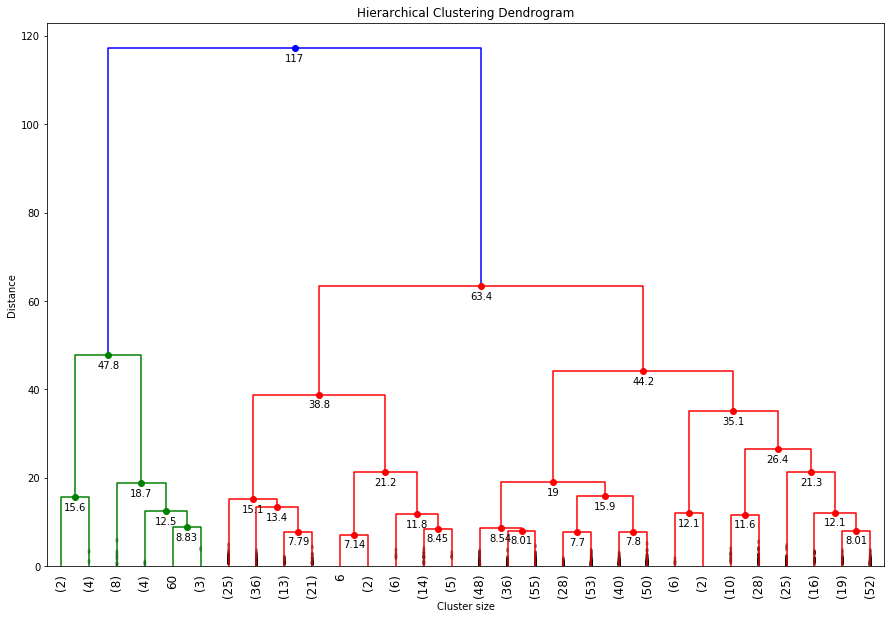

In [32]:
#Drop uninformative columns
campaign_clust=campaign.drop(columns=['ad_id','fb_campaign_id'])

#Reindex so we can know column index
campaign_clust=campaign_clust.reindex(['gender','interest','age',
                                     'Impressions',
       'Clicks', 'Spent', 'Total_Conversion', 'Approved_Conversion', 'CPM',
       'CTR', 'CR_Approved', 'CR_Total', 'CPC', 'ROAS'],axis=1)

#Scale non-categorical values
scaler=RobustScaler()
num_scaled=scaler.fit_transform(campaign_clust.iloc[:,3:])
num_scaled=pd.DataFrame(num_scaled,columns=list(campaign_clust)[3:],index=campaign_clust.index)


#Create hierarchical matrix encoded as linkage matrix using the Ward variance minimization method
Z = ward(num_scaled)


def plot_dendrogram(Z,p,truncate_mode='lastp',max_d=None,leaf_rotation=90.,
    leaf_font_size=12.,show_contracted=True,annotate_above=10):
    '''Creates dendogram with horizontal line at max_d'''
    plt.figure(figsize=(15,10))
    
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Cluster size')
    plt.ylabel('Distance')
    
    dendro=dendrogram(Z=Z,p=p,truncate_mode=truncate_mode,leaf_rotation=leaf_rotation,
               leaf_font_size=leaf_font_size,show_contracted=show_contracted)
    
    for i, d, c in zip(dendro['icoord'], dendro['dcoord'], dendro['color_list']):
        x = 0.5 * sum(i[1:3])
        y = d[1]
        if y > annotate_above:
            plt.plot(x, y, 'o', c=c)
            plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
    if max_d:
        plt.axhline(y=max_d, c='k')
    return dendro

#Plot Dendogram
_=plot_dendrogram(Z=Z,p=30,truncate_mode='lastp',leaf_rotation=90.,
    leaf_font_size=12.,show_contracted=True,annotate_above=2)

In the dendrogram above, we can see different levels of granularity and the size of each cluster as we move up the hierarchy.  With the help of this visualization, we can select how many clusters we want to look at by specificing the height at which we "cut" the dendrogram.  For our analysis, let's select a height of 18.

In [37]:
#Specify max distance between clusters
max_d=18
clusters = fcluster(Z, max_d, criterion='distance')
num_scaled['cluster'] = clusters
campaign_clust['cluster'] = clusters
print(num_scaled.groupby('cluster').count().iloc[:,0])
num_scaled.groupby('cluster').mean()

cluster
1       6
2       8
3       8
4      95
5       3
6      25
7     139
8     171
9       8
10     38
11     25
12     87
Name: Impressions, dtype: int64


,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,CPM,CTR,CR_Approved,CR_Total,CPC,ROAS
cluster,,,,,,,,,,,
1,-0.475170,-0.452736,-0.467919,-0.041667,0.250000,-1.547974,-1.252489,19.922754,10.923260,0.541014,19.750187
2,-0.470566,-0.423507,-0.437200,0.000000,0.125000,-0.570718,-0.428852,7.110254,3.692746,0.238497,7.240611
3,-0.386324,-0.404851,-0.419072,0.625000,0.812500,-1.323007,-0.971977,10.504573,6.546474,-0.210161,11.949941
4,1.796111,2.020896,1.928509,1.368421,0.473684,0.480032,0.609206,-0.113689,-0.313861,-0.193641,-0.237391
5,6.467683,4.313433,4.765306,11.000000,8.000000,-0.321917,-0.294659,0.916629,0.642682,0.646526,0.780584
6,2.689711,2.097313,2.254248,4.900000,3.420000,-0.056749,-0.035160,0.684787,0.562751,0.362725,0.649020
7,-0.019962,0.148502,0.116009,-0.028777,-0.276978,0.763248,0.835941,-0.137937,-0.229448,-0.184724,-0.233082
8,0.154258,0.070786,0.098632,0.190058,-0.140351,-0.188819,-0.154751,-0.096495,0.084648,0.315861,-0.150273
9,-0.499281,-0.460821,-0.476245,-0.156250,-0.500000,-1.428614,-1.126810,-0.377246,9.913233,0.349459,1.917700


With this height, we have 12 clusters, which is a reasonable number of clusters.  In the table above, the values of the KPI's have been scaled using the RobustScaler, so we can quickly discern differences among the KPI values of the clusters.  There are several notable clusters that can give good insight into the campaign.  Earlier, when we were looking at the ROAS outliers, we noted that the advertisements were on a smaller scale than other ads, so it made it more difficult to confidently draw conclusions from these advertisements.  This phenomena is evident in the table, with clusters 1,2,3, and 10 having high ROAS values but a relatively low number of impressions.  

If we want to examine advertisements with a good ROAS that were run at a very large scale, we can look at the advertisements in cluster 5.  As evidenced by the large value for impressions, total conversions, and approved conversions, these advertisements were very large, and produced a significant amount of revenue.  While this cluster only contains 3 ads, their scale and good ROAS values could provide valuable insight into potential drivers of the campaign.  For example, it could be worthwhile to emulate the design, message or placement used in these ads to target other groups since it is clear they are effective on a large scale.  

It could also be worthwhile to examine similarities among advertisements in cluster 12.  These advertisements were run on an average scale with a better than average ROAS.  There are also 87 advertisments in this cluster, so we could gather more insight about the target demographics and content within these advertisments. 


Overall, hierarchical clustering proved a useful approach to segmenting the advertisements on the basis of similarities among KPI's.  With these segments formed, it would be possible to examine the properties of the advertisements within and ultimately draw conclusions on how to optimize the overall campaign strategy.  Of course, this type of analysis is far from perfect.  Many of the modeling decisions, such as the parameters chosen for distance, linkage, scaling, and height, had a significant impact on how the clusters formed.  While not shown in this notebook, several other linkage criteria were tried but the resulting clusters did not lend themselves to useful interpretation.  Significantly, we were able to gather meaningful insight from this analysis.  A possible extension would be  assessing the robustness of some of the clusters formed by applying a different clustering technique such as K-Means clustering to the data set and comparing the results.

## Conclusion

In this notebook, we performed exploratory data analysis, built useful KPI's, and investigated ROAS outliers.  We then  examined demographic differences in campaign effectiveness, and concluded our analysis using hierarchical clustering.  Given the anonymous nature of the data, it was difficult to make concrete statements regarding the optimal campaign strategy. However, we were still able to draw meaningful insights from the data that could help inform business decisions.  Thank you for reading!